In [3]:
from helpers import *
from distances import *
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax_md import (
    energy
)
# jax.config.update("jax_enable_x64", True)

In [27]:
N = 128
dim = 2
avg_number_density = 0.1

In [28]:
box_size, displacement, shift = init_periodic_box(N=N, dim=dim, avg_num_density=avg_number_density)

In [29]:
def uniform_square(key, N):
    return jr.uniform(key, (N, 2), minval=0.45*box_size, maxval=0.55*box_size)

In [30]:
num_keys = 10
keys = jr.split(jr.PRNGKey(0), num_keys)

In [31]:
all_states = brownian_simulation_vec(keys, 0.5, 0.0001, jnp.arange(1000), N, shift, energy.lennard_jones_pair(displacement, sigma=1, epsilon=1, r_onset=0.9, r_cutoff=20), uniform_square)
# all_states = brownian_simulation_vec(keys, 0.001, 0.0001, jnp.arange(1000), N, shift, lambda r: 0., uniform_square)

In [32]:
print(jnp.shape(all_states))
# jnp.save("brownian-lj", all_states[0, :, :, :])

(10, 1002, 128, 2)


In [33]:
correction = 0.5*box_size*jnp.ones_like(all_states)
states_corrected =  all_states - correction

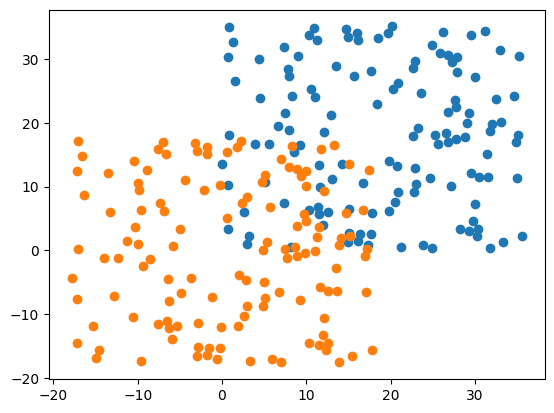

In [34]:
plt.scatter(all_states[0, -1, :, 0], all_states[0, -1, :, 1])
plt.scatter(states_corrected[0, -1, :, 0], states_corrected[0, -1, :, 1])
plt.show()

In [35]:
def euclidean_norm(p):
    """
    Euclidean norm of collection of points in R2

    Inputs:
    -----------
    p: Array, (N, 2)

    Returns:
    ------------
    _: Array, (N,)
    """
    return jnp.sqrt(p[:, 0]**2 + p[:, 1]**2)

In [36]:
def euclidean_norm_sims_and_times(p):
    return jax.vmap(jax.vmap(euclidean_norm, 0), 0)(p)

In [37]:
norms = euclidean_norm_sims_and_times(states_corrected)

In [38]:
print(jnp.shape(norms))

(10, 1002, 128)


In [46]:
nbins = 1000
dr = box_size/(nbins)
rr = jnp.arange(dr, box_size+dr, dr)
# rr = rr[:-1]
print(jnp.shape(rr))

(1000,)


In [40]:
rdfs = rdf_pairwise_times_and_sims(norms, dr, nbins)

In [41]:
print(jnp.shape(rdfs))

(10, 1002, 1000)


In [42]:
rdfs_avg = jnp.mean(rdfs, axis=0)

In [43]:
print(jnp.shape(rdfs_avg))

(1002, 1000)


In [47]:
annuli_areas = 2*jnp.pi*rr*dr
normalisation = jnp.roll(annuli_areas, 1)
normalisation = normalisation.at[0].set(jnp.pi*dr*dr)
all_normalisation = jnp.tile(normalisation, (1002, 1))

In [48]:
normalised_rdfs_avg = rdfs_avg/all_normalisation

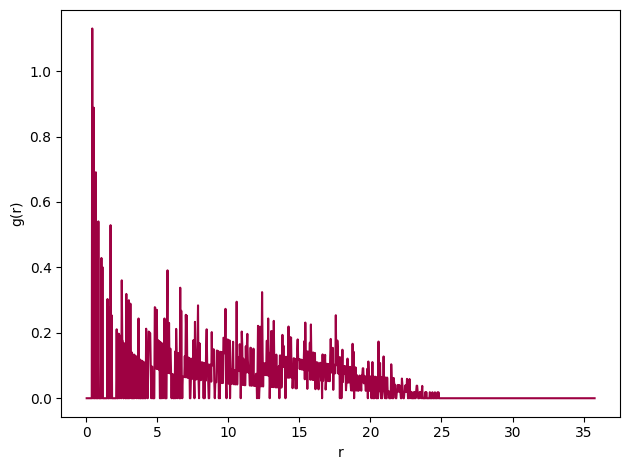

In [51]:
from cycler import cycler
fig, ax = plt.subplots()
custom_cycler = cycler("color", plt.cm.Spectral(jnp.linspace(0, 1, 1000//100)))
ax.set_prop_cycle(custom_cycler)
# ks = jnp.arange(5, 1002, 100)
# for k in ks:
    # ax.plot(rr, rdfs_avg[k, :])
# ax.plot(rr, rdfs_avg[-1, :])
ax.plot(rr, normalised_rdfs_avg[-1, :])
ax.set_xlabel("r")
ax.set_ylabel("g(r)")
#ax.set_ylim([0, 1000])
plt.tight_layout()
#plt.savefig("bm_lj_rdf_low_density_low_temp_init_cluster_periodic_box_first_density", dpi=300)
plt.show()